`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
from scipy.io import loadmat
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
from scipy.io import netcdf
import netCDF4 as nc


/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:220: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if num_peri_dims is not 0:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:252: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if num_peri_dims is not 0:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:896: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(staggerloc) is 1:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/util/slicing.py:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert (len(slc) is 3)
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/mesh.py:141: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if meshname is not "":
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/mesh.py:145: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if varname is not "":


In [2]:
haumann = loadmat('glodapv2_2016b_mapped_ppco2_gamman.mat')
lev = haumann['dpth']
gamman = haumann['gamman']
lat = haumann['lat']
lon = haumann['lon']
ppco2 = haumann['ppco2']
vol = haumann['vol']

In [3]:
PCO2 = xr.DataArray(data=ppco2,
            dims=["x", "y", "lev"],
            coords=dict(x=lon[:,0,0], 
                        y=lat[0,:,0], 
                        lev=lev[0,0,:])
            )
PCO2 = PCO2.roll(x = 20, roll_coords = True)

ndensity = xr.DataArray(data=gamman,
            dims=["x", "y", "lev"],
            coords=dict(x=lon[:,0,0], 
                        y=lat[0,:,0], 
                        lev=lev[0,0,:])
            )
ndensity = ndensity.roll(x = 20, roll_coords = True)

In [4]:
nd = ndensity.sel(x=slice(180,200)).mean(['x'],keep_attrs=True)
nd = nd.transpose('lev','y')
nd

<xarray.DataArray (lev: 33, y: 180)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ..., 29.15177,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) uint16 0 10 20 30 50 75 100 ... 3000 3500 4000 4500 5000 5500

<ipython-input-8-c121b97d3046>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(d2.y, d2.lev,d2, vmin = 300, vmax = 600)


Text(53.625, 0.5, 'Depth (m)')

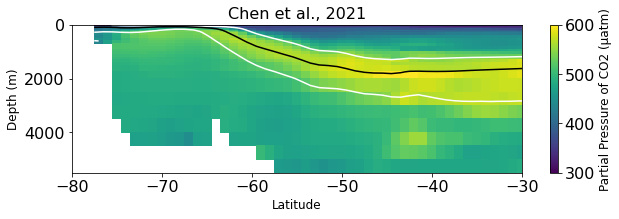

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[10,4])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=14)


ds = PCO2.sel(x=slice(180,200)).mean(['x'],keep_attrs=True)
d2 = ds.transpose('lev','y')

ax.set_xlim([-80,-30])
# ax.set_ylim([0,1000])
im = ax.pcolormesh(d2.y, d2.lev,d2, vmin = 300, vmax = 600)
ax.contour(nd.y, nd.lev, nd, levels=[27.5, 28], colors = 'w')
ax.contour(nd.y, nd.lev, nd, levels=[27.8], colors = 'k')
cbar = plt.colorbar(im,ax=ax)
ax.invert_yaxis()
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax.set_title('Chen et al., 2021')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')
# ax_idx += 1

Text(53.625, 0.5, 'Depth (m)')

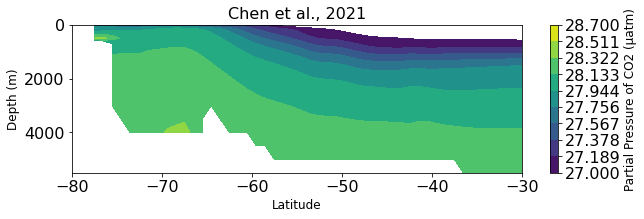

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[10,4])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=14)



ds = ndensity.sel(x=slice(180,200)).mean(['x'],keep_attrs=True)
d2 = ds.transpose('lev','y')

ax.set_xlim([-80,-30])
im = ax.contourf(d2.y, d2.lev,d2, vmin = 27, vmax = 28.7, levels = np.linspace(27, 28.7, 10))
cbar = plt.colorbar(im,ax=ax)
ax.invert_yaxis()
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax.set_title('Chen et al., 2021')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')
# ax_idx += 1

In [33]:
help(pcolormesh)

NameError: name 'pcolormesh' is not defined

In [5]:
PCO2.sel(x=slice(180,200)).mean(['x'],keep_attrs=True)[:,0:60].min()

<xarray.DataArray ()>
array(166.64771752)